# Machine Learning Foundation

## Section 2, Part c: Cross Validation 


## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`

To download the data set (.pickle file) click [HERE](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle)


Welcome to our third notebook here in the second course on cross-validation. In this notebook, we will discuss how to chain multiple data processing steps together using the pipeline functionality, which will allow you to speed up a lot of your Machine Learning workflow. We'll talk about using the KFolds object to split data into multiple folds as we saw in lecture, and then we'll learn how to perform cross-validation using sklearn's cross_val_predict, as well as the GridSearchCV to see how well we are able to perform given our model on each one of these folds. Now, as usual, we're going to bring in many different libraries. Let's go down to the second line here on sklearn. From model selection, we're going to bring in the objects we just mentioned, KFold and cross_val_predict. From the linear model, we're not just going to bring in linear regression, but we're also going to introduce lasso and ridge regression. We're going to talk more about these in detail during lecture, but note that these are just linear regression plus a way of ensuring that you don't overfit that linear regression. Then from metrics, we're bringing in the r2_score, which is just r squared, and then from pipeline, we're bringing in the pipeline function.

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install wget
import wget
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now our dataset this time is going to be saved in a pickle file. This pickle file is actually a dictionary. Pickle allows us to save Python objects and be able to achieve them easily. So we're going to open up this pickle file that we have here. If we look at boston.keys, we see this is a dictionary with the keys dataframe and description, and we're going to pull out the pandas DataFrame specifically, call that boston_data, and then we're also going to plot the boston description to separate these two out into their own objects. Then we see we have the pandas DataFrame and we can look at the first five rows and see the median value is what we're trying to predict for the housing and we also have all these different features in order to help us predict that median value.

In [2]:
## Note we are loading a slightly different ("cleaned") pickle file
# !wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle
# boston = pickle.load(open('data/boston_housing_clean.pickle', "rb" ))
# boston = pickle.load(open('boston_housing_clean.pickle', "rb" ))

In [3]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"
downloaded_file = wget.download(url)

In [4]:
with open(downloaded_file, 'rb') as to_read:
    boston = pd.read_pickle(to_read)

In [5]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [6]:
!python --version

Python 3.11.9


In [7]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [8]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

Now we know, given our discussion and the subject of this current notebook, that our goal is going to be, how can we predict future values when we only have the data available to us in this dataset? So what we're going to want to do is use KFolds and separate out into three different folds, three different train and test sets, and we want to think about how are we going to do this in Python code.

**Your response below**


#### Coding this up

So to code this up, the first thing that we want to do is separate out our x and y variables, our features x, and our target variable y. So x is just going to be equal to boston_data, and we're doing.drop just to remove the outcome variable, and then y is just going to be equal to the outcome variable.

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:


In [9]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

Then as we've done so far with sklearn, we're going to want to initiate an object. So we're going to initiate our KFold object before using it, and we're going to pass into that initiated object certain arguments. When we say shuffle equals true, if you recall when we were looking at a DataFrame, we can take the first 10 and leave, let's say it was DataFrame of 100 values, we can take the first 10 and leave out the next 90, and then take the next 10. So we started off with zero to nine, and then 10-19, and each one of those can be the different test sets, or we can shuffle it and choose a random 10 to be our test set, the rest being our training set, and then take another random 10. This will become clear as we actually look at the indices that we're pulling out in the next couple of cells. So we're going to shuffle that, so it's not just an order, and then we set our random state, and then the other important argument that we need to pass is the number of splits. So how many times do we want to split up our DataFrame? We're going to have three folds, meaning three training sets and three test sets, where none of the test sets are going to overlap. If you recall from lecture, the training sets can overlap, but the test sets have to be exclusive so that we are looking at different test sets every single time.

In [10]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

Let's actually look at what kf.split does for us. That's going to give us a generator object. That generator object you can think of as a list. A list where each value in that list is a tuple. That tuple is going to be first, all the indices that we want to set to our train index, and the second part of that tuple is going to be the test index. So it's going to be three tuples, each one with a train index, giving all of the indices taken from our DataFrame, taken from our x, so it's going to be the same size, and then our test index, which is just going to be again, the indices just specifying the test Index. We have our train index, that's just going to be a list of numbers, and that list of numbers is going to be somewhere between, let's just look at x.shape, it's going to be within 506. So values between zero and 505, all the way up until the end.

In [11]:
kf.split(X)

<generator object _BaseKFold.split at 0x0000028ABAD10CA0>

In [12]:
X.shape

(506, 13)

In [13]:
X.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88


We're going to look at the first 10 values for each one of our train and test splits. That's the first 10 here (`[:10]`)and then we're also going to get the length of our train index and the length of our test index.

Now, think about what the length of our train and test indices should be. If we're splitting into three, then we know that our tests indices should be around one-third of the length of our entire data set. I'm going to run this and we see that 170, which is around one-third of 505, is going to be our tests index size, and it's going to be the same for each one of these folds. One of them is one-half, just because it didn't cleanly divide by 3. But we see that each one of these lengths for test index is going to be around one-third, and then the remaining two-thirds are going to be the size of our training index. All the values that we're going to eventually want to train our model on. We also see that we have the actual indices, just the first 10, here for the train index. Remember, the train indices can overlap, and you should see some overlap. Here, you see the two and the two, two and two, and there should be some overlap, but the tests indices will not have any overlap. These are each going to be unique and these are going to be different holdout sets. We're going to train on this training set and then test on this test set. Then we're going to train on this train set and test on this test set, and so on.

In [14]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



Now, we want to to the scores for each one of our train and test splits. We're going to start off with a blank list for scores. We're going to initiate our linear regression object. Now, we have our predictor, it's lr, and we're going to say for train index and tests index in our split. Again, the split was defined earlier and we saw what that output will look like. That'll be a train index and a test index will run through that, and then we'll get to the next tuple of train and test indices. We're going to set our x_train, x_test, y_train, and y_test to the following outputs. It's going to be x, so our original x with all of our rows, but we're only going to take the rows for our first train index, and we're obviously going to take all of our columns from x. We're then going to set to x_test all of our test indices. So now we've set the x_train and the x_test. Then y_train is just going to be y and it's going to be the matching train index to our x_train that we specified first, and then we're going to set our y towards the test index to match up with the x_test index, which we defined here with x_test.

We're then going to fit our model to our training set. Again, this is going to be a for loop. So it's going to do this three times. Using our first training set, we're going to do lr.fit on x_train and y_train. We're going to come up with our predictions on x_test. Again, we fit to our training model and then we test what the predictions will be, assuming we didn't have the labels for x_test, we get our prediction. Then we can say for that prediction, how well did we do according to the actual values that we held out in our test set. So you get the r2_score of y_test.values and y_pread. So r2_score we brought in earlier, recall that was one of the metrics that we pulled in. We set that equal to our score and then we add that onto our original list that we had empty at first. We're going to do this for three different splits. We'll run this code and you see that it will output three different results for each one of those test and training sets, and this also makes clear how you can end up with fairly different values depending on what your test set is. This highlights the importance of doing multiple folds, and then eventually, if you're doing cross validation, you would end up averaging these all together.

In [15]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472737, 0.7485020059212378, 0.6976807323597766]

A bit cumbersome, but do-able.


### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?


**Your response below**


Here we're going to discuss adding in a preprocessing step, as well as introducing the pipeline and the cross val predict, which we'll see will consolidate a lot of the code that we're writing out in this next step.

### Coding this up

Similar to before, we're going to start off with just an empty lists for scores. We're going to initiate our linear regression object to lr, and then we're also going to add on this preprocessing step of scaling our data. That's going to be this s equals StandardScaler. We're then going to run that same for-loop using our kf.split, and end up with an x_train, x_test, y_train, and a y_test set. We're then going to take our x_train and then fit and transform it using our StandardScalar. We're going to come up with that mean and standard deviation, and subtract the mean, divide by the standard deviation, and come up with this new x_train_s. We've now scaled our data. We're then going to pass in our scale data along with our original outcome variable just for the training set, and we're going to fit our linear regression model on our training set. We then have to transform our test set, getting it to the same scale using what we learned from the standard scalar on the training set. So we just run s.transform on our test set, we get the output when we subtract the mean and the standard deviation of x_test_s, we can then pass that into our linear regression model that's fitted to our training set and come up with predictions on that test set. We can then use those predictions in order to see r2_score between the actual values and our predictions. Then just as we did before, we'll keep appending on the new scores into our scores list. Then we see here that our scores are exactly the same and that's because for vanilla linear regression, without any regularization, and that's going to be a term we'll introduce later on, but the idea there being that there's lasso and ridge, which we talked about, which will allow you to prevent overfitting. Those will need you to scale your data for regular linear regression. Scaling won't actually affect performance.

In [16]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [17]:
scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597745]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)


This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

As we add on more and more preprocessing steps, this can become pretty cumbersome to keep adding on and doing your fit transform, then your next fit transform if you have another preprocessing step, and then when you want to run it on the test having to transform each one of those. Luckily, Sklearn recognizes that this is common within the machine learning work for, and they have introduced the pipeline functionality. Pipelines are going to allow you to chain together multiple operators on your data as long as they each have a fit method. They all have to have a fit method, and then on top of that, every step leading up to the last step has to have a fit and transform so that the output of one can be the input of the next step. So you can chain together more than two steps. You can chain together 10 steps as long as each one of those steps has fit transform, and the last step has fit.

### `Pipeline` and `cross_val_predict`


`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

We're going to reinitiate our StandardScaler and our linear regression, and then we're going to introduce our pipeline function.

In [18]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

Recall we imported pipeline earlier from sklearn.pipeline, and we're going to set this variable estimator equal to our pipeline. Our pipeline's going to have two steps. First, it will scale our data, then it will pass that through to a linear regression. This will allow us to bypass those steps that we saw above of fit transform as well as transform when we actually want to test.

In [19]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

To show you what that looks like, we're going to quickly introduce the code. We have estimator now created, that object is created. Similar to what we do with linear regression, we can actually just pass in our x_train and our y_train. We have now fit that pipeline objects specifically to the x_train and y_train. What we've done there is we first scaled our x_train data, and then we ran regression, so we fit the data according to the scaled version of the data.

In [20]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regression', LinearRegression())])

Now that the estimator is fit to the data, we can even call estimator.predict, similar to what we do with linear regression and pass it in our x_test, and it will create an actual prediction.

In [21]:
estimator.predict(X_test)

array([19.44230308, 22.8687781 , 20.72201438, 20.19685225, 16.02553328,
       13.19670707, 18.48717304, 16.41260539, 20.08040483, 19.16027923,
       23.03341265, 23.52809897, 24.64808538, 23.84554003, 22.37992895,
       18.54423788,  9.23453025, 24.86310535, 27.35965358, 29.95093715,
       21.71928179, 18.63649236, 19.67735609, 29.98064881, 20.78659698,
       17.29484103, 20.88767674, 23.59352298, 23.01287114, 24.82516061,
       28.1550891 , 26.59019417, 28.40170962, 28.61954803, 28.99730977,
       25.46130359, 20.83346878, 21.39384122, 21.12590183, 24.80991192,
       22.64896843, 20.63582629, 20.04498128, 20.28679691, 16.04272023,
       15.75494076, 12.78067624, 11.43558055, 21.98898014, 23.31730716,
       24.28692882, 21.28789025, 14.88646576, 31.00959189, 35.37282463,
       37.57270926, 23.58942636, 24.75302163, 30.63215847, 34.85770942,
       32.94090699, 30.0536187 , 39.86200512, 29.05010705, 35.53401305,
       41.89294309, 23.54417467, 23.61752172,  8.51966664, 24.38

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

Now, rather than doing that for-loop, if we want to get the prediction for each one of our holdout sets in our K-folds, we can use this function called cross val predict. The way that works, first, let's reintroduce that. We have this K-fold objects, which will specify that we want three splits and that we want it to shuffle rather than doing it in some type of ordering.

In [22]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

We're going to pass in that K-folds object here into our cross val predict, which is why we reintroduced it. We're going to say, I want to form my estimator, and that's the pipeline that we created above. For my initial values of x, so no splits, the cross val predict will do the splitting for you. For my initial y, I want to pass in how many folds? So you can say I want the K-folds object that we specified here, which will ensure that you're not just passing in three splits, but also that it's a shuffle, it'll be a specific type of split. You could also just pass into here for your CV, the number 3, and that will create three splits, but they may not be shuffled. This allows you to specify exactly how you want it to split.

Then when I run predictions, that will output predictions, giving that it's going to train on two-thirds and then predict for the other third. After it predicts all three of those thirds, it will have predicted for every single value in our dataset, but only using training from different subsets of that dataset. That's how the cross val predict works. We have our training set which is two-thirds, and a holdout set that is one-third. So we're predicting that one-third and then we're using a different two-thirds to predict another one-third.

In [23]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

Now we have our predictions. I'm going to run the length of our predictions and you see that it's the same length as the length of our actual dataframe.

In [24]:
len(predictions)

506

Then going to check the r2_score on our predictions compared to the original y, and we see that that's almost identical. I'm going to run that here. These are the scores that we had above in regards to calling out every single one, one at a time.

In [25]:
r2_score(y, predictions)

0.7063531064161561

In [26]:
np.mean(scores) # almost identical!

np.float64(0.7060392060427613)

That's how the cross val predict will work. What's important to note is that the cross val predicts did not actually fit the model at any step along the way. It's going to give you all the outputs, but it essentially came up with three different models; one trained on the first two-thirds, one trained on the next two-thirds, and so on.

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 


## Hyperparameter tuning

As a quick recap, hyperparameters versus parameters, the hyperparameter's to be parts of our model that we as users will actually tune ourselves, versus parameters, which will be learned by the model using machine learning.

Now, how do we come up with these hyperparameters in order to optimize the model performance? The way that we do this is going to be a hyperparameter tuning, and that's going to involve using cross-validation, so multiple train test splits, as we just did, in order to determine which hyperparameters are most likely to generalize well for an outside sample. So like we saw in lecture, we had that curve and regards to the complexity versus the error, we want to find that perfect part of the curve. So we'll test many different hyperparameters to see which one of those hyperparameters will lead to the right level of complexity to minimize our error on a holdout set. So generally speaking, tuning those hyperparameters will increase or decrease the level of complexity of your model.

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics




So a quick introduction to a function that we're going to use here, the geomspace. The geomspace is just going to be, here we say 1 through 1,000 and the number of values you want is equal to 4. It's just that every single value in between will be a multiple of the prior value. So 10 is 10 times 1 and 100 is 10 times 10 and 1,000 is 10 times 100. You can think of this in the same way and np.geomspace. And I can say 1, 27, 4, and you see that each one's 3 times the prior value.

In [27]:
np.geomspace(1, 27, 4)

array([ 1.,  3.,  9., 27.])

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

So here we're going to create 10 value starting with 1 times e to the negative 9, 1 times 10 to the power of negative 9, which is going to be 0.00, that many zeros one, up until just one itself.

In [28]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

So we see that, that this is to the negative 9, negative 8, negative 7, so on and so forth till we get to 0.01, 0.1, and then just 1.

So we have not yet introduced lasso, and all I mentioned before and all you need to know here is that changing this alpha value within lasso. So we're going to use this lasso model and we're going to initiate the same way we do with linear regression. And we're going to pass in this argument to alpha for each one of the alphas that we defined before. All you need to know is that the higher the alpha is, the less complex your model is. The lower the alpha is, the more complex it is, and the closer it is to regular linear regression. And this will become even clearer as we go through the outputs of the actual coefficients for each one of our features that we have in our data set.

The code below tunes the `alpha` hyperparameter for Lasso regression.

So we're starting off with scores is equal to a blank list, and the coefficients is equal to a blank list. And what we're going to want to do is actually see which one of our different alpha values is going to lead to the highest score for our holdout set. So that's going to allow us to look through each one of these hyperparameters, each one of them being an alpha, and see how much do we need to limit the complexity of our model. So we, for every alpha, initiate our lasso model.

We're then going to run our estimator, create our estimator using pipeline.

Now, we'll get into this later as well, but it's very important whenever you're doing lasso or ridge regression, and we'll show you ridge regression in a second, that you scale your data first. Always have to scale your data, otherwise the model will not work optimally.

So we scale it, then we run lasso regression, so similar to the pipeline that we saw above.

And then we just get our predictions using cross val predicts. We pass in our estimator, our x, our y, and how we want to do cross validation. And then we get our r2 score and append that to our scores. So we're going to do that for each one of our alphas.

In [29]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

And then we can look at for each one of our alphas what our score was. So this is the most complex of the models, and this is the least complex. And we see that it performed, it has a pretty flat curve in regards to how much lowering complexity is actually helping in regards to our holdout set.

In [30]:
list(zip(alphas,scores))

[(np.float64(1e-09), 0.7063531064981925),
 (np.float64(1e-08), 0.7063531072356071),
 (np.float64(1e-07), 0.7063531145602442),
 (np.float64(1e-06), 0.7063531882052063),
 (np.float64(1e-05), 0.7063539165191507),
 (np.float64(0.0001), 0.706361268093463),
 (np.float64(0.001), 0.706433467041546),
 (np.float64(0.01), 0.7070865958083233),
 (np.float64(0.1), 0.705838151167185),
 (np.float64(1.0), 0.6512724532884888)]

So, Just to make clear how we are actually making it more or less complex of a model. If we look at the coefficients for very little alphas, for those that will reduce complexity much less, you see that our coefficients are all different numerical values. Whereas if I do alpha equals 1, which is much higher alpha value, so much less complexity, we end up removing many of our coefficients, right? These coefficients are each going to relate to a feature, and we have removed those features, essentially, from our prediction values.

In [31]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [32]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

And I'm going to plot this and we're going to be able to see the trade-off between higher complexity and our error rate. And we see that it's fairly level throughout.

So we probably do not need as much regularization as we're just working with plain lasso with just the standard scalar. We're going to see in a second, as we end up with many more features using something like polynomial features, how we'll need to actually reduce the complexity, and probably move many of these actual interaction terms or squared values.

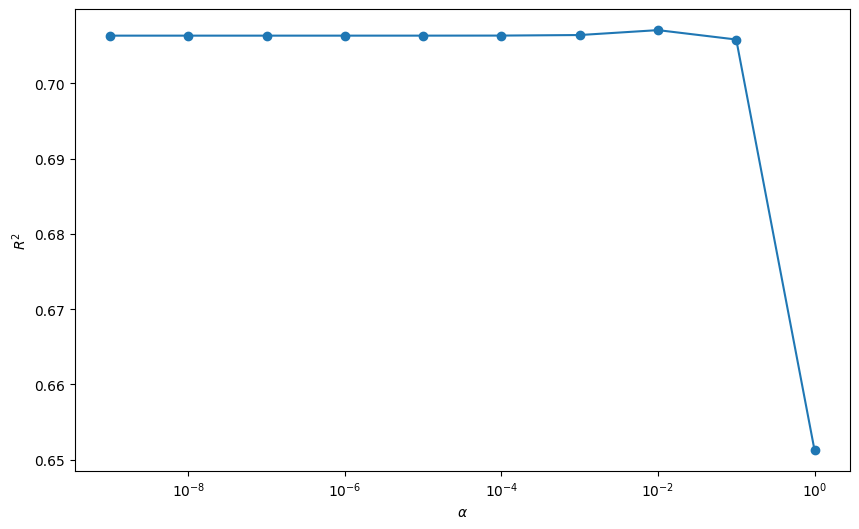

In [33]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

So if you think about it, now there's a little bit of an argument here. But on one side, if you standardize first, then you will end up with negative and positive values for values that may have all been positive, therefore changing all of your interaction terms. Also, you're going to be bringing them down to a much smaller scale. So rather than the first value times the second value both being above 1 and therefore increasing that vale even mor. If you scale it down to values that are maybe 0.5 and 2, we're actually reducing that value.

So that's on one end of the argument why we would want to do polynomial features first, and then scale it down.

Also on top of that, scaling it second will also ensure that each one of them are on the same scale at the end.

On the other hand, you may want to know the interaction between the scale data so that you'd be able to see, just in regards to how much one varies from the mean, what will be the interaction versus the squared of those values.

But we're going to stick here with just the polynomial features first, which is generally regarded as best practice.

We're going to initiate our polynomial features object. We're going to start off with a blank list of scores, as we did before. We're going to have our list of alphas. And then for each one of those alphas, we're going to do the same as we did in regards to initiating our lasso object. Now, I do want to say that we have this max iteration, which we didn't discuss before. The idea being that when you're working with lasso regression, it's actually going to work with radiant descent, which we haven't introduced yet. The idea is for it to get to the optimal value, it's essentially running in the back end, what you can think of as for loop, as it gets closer and closer to the correct value. And it's going to do that in small little steps, and if you don't have enough iterations, and the default here is not enough iterations, then it won't get to that optimal value. So that's why we have to set the max iterations.

We're then creating our estimator object, which starts with the polynomial features, then scales it, and then pass that through to our lasso regression.

We're then going to come up with predictions by just running cross val predicts, passing in our estimator, our x and our y. And then we're going to get our new score and we're going to append each one of these scores. Now, running this will take about 30 seconds. Also note that you will probably get a warning giving the max iterations that we have here, that it hasn't converged. But we tested this on the back end to ensure that the numbers are fairly close to the actual optimal value. So I'm going to take a break here, and we'll come back as soon as this is done running.

In [34]:
pf = PolynomialFeatures(degree=2)
scores = []

alphas = np.geomspace(0.001, 10, 5)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    estimator = Pipeline([
        ("make_higher_degree", pf),
        ("scaler", s),
        ("lasso_regression", las)])
    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    
    scores.append(score)
scores

[0.8465056899967298,
 0.8552553819994727,
 0.8124536477296069,
 0.7090474482089187,
 -0.000616160136140298]

Okay, now our functions have ran and we can look at for each one of our alpha values what are different scores were. And we see, starting off with very little alphas, so very high complexities that we may not be generalizing well. We see with a little bit more of a little bit higher of an alpha, then we are generalizing better. And then as that alpha gets even higher, we may have reached our peak.

In [35]:
alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

If you store the results in a list called `scores`, the following will work:


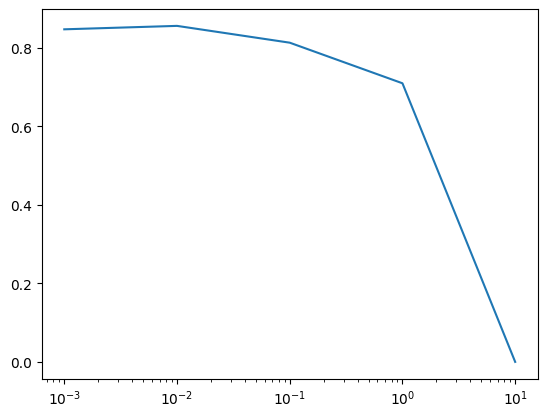

In [36]:
plt.semilogx(alphas, scores)

So to look at this graph we would say that at this 0.01 we probably got our optimal value in regards to the hyperparameter that will generalize well to new new data coming in.

So with that, we can then use that hyperparameter to train our actual model. So we're going to set our best estimator equal to this pipeline where your polynomial features degree equals 2. Then scaling, and then using the alpha that we found was the best value with 0.01, and we can fit that. We see what the score was here for the best estimator, which will be built in, and it will be by default the r2 score. And when we are looking at that, we have to keep in mind also that we are training and scoring on the same data set. So generally speaking, as usual, we probably want to have a holdout set. But this is just to show us how much of our variation we were actually able to cover given the model that we used.

In [37]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.01, max_iter=10000))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9032551408154241

And then when we look at the coefficients, because we used the lasso regression and we added this alpha term, we actually removed many of these features, as you see a lot of them essentially zeroed out.

In [38]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.61127587e+00,  0.00000000e+00,  6.24240557e-01,  0.00000000e+00,
       -7.22878514e+00,  9.74968793e+00,  0.00000000e+00,  0.00000000e+00,
        6.34548325e-01,  0.00000000e+00,  9.95741679e-01, -5.51374291e-03,
       -0.00000000e+00,  2.44370838e+00, -2.40444044e+00, -0.00000000e+00,
       -0.00000000e+00, -2.23044443e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.88128934e-01,  5.17203914e-01,  3.07715719e-01,
       -3.39853933e-01, -9.86590910e-02, -0.00000000e+00,  2.72847487e-01,
       -0.00000000e+00, -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,
        0.00000000e+00, -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.63148300e+00,
       -2.62941147e-01,  0.00000000e+00,  9.08410143e-01, -8.17144528e-01,
        0.00000000e+00, -4.31628234e+00,  5.53254405e-01, -2.91912598e+00,
       -4.68486241e+00,  

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?


Here we're going to briefly introduce ridge regression. Now again, we haven't gone through the math of ridge and lasso regression. All we need to know is that these are two different forms of reducing the complexity of the original linear regression model. So that's all we'll know for now, we'll get deeper into the math in lecture. Now as before, before passing through to our new model here being the ridge regression, we're going to create our PolynomialFeatures object, we're going to add certain Alphas that we're going to search through, and we're going to initiate just blank scores that we will append as we get the scores for each one of our ridge regressions given the different hyperparameters that we're passing through. Again, our goal is to find the optimal hyperparameters so that it generalizes well to new data. So we don't want it to be too complex, but we don't want it to be a minimal amount of complexity. We want that just write region and we do that by doing cross-validation and saying for each one of these Alphas, either reducing complexity a turn or just a bit, where is the right balance in regards to complexity to minimize the error on our holdout sets. We're doing for Alpha in our Alphas, we run our ridge regression and for each one we pass in this hyperparameter of our Alpha. We also are passing in this max iteration to ensure that it will converge as we discussed. We will initiate our estimator object again using a pipeline of polynomial_features, the standard scalar, and then ultimately our ridge_regression, which we defined above and then we'll get our predictions using the cross _val_predict on each one of our holdout sets and then we can see the r2_scores for each and append that onto our scores. Then we'll plot in order to see how the Alphas versus the scores, how that's going to increase or decrease our r2_score as we increase or decrease our complexity using these Alphas.

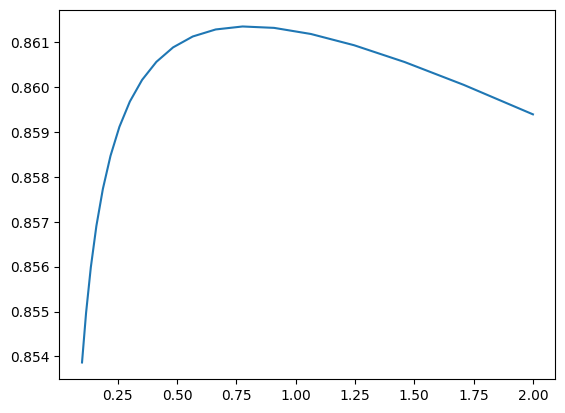

In [39]:
pf = PolynomialFeatures(degree=2)
scores = []

alphas = np.geomspace(0.1, 2, 20)
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("polynomial_features", pf),
        ("scaler", s),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)
plt.plot(alphas, scores)

Recall that a lower Alpha means more complexity. So we see all the way here to the left with much lower Alpha, we are not getting as high of an r2_score but as we increase the Alpha and reduce the complexity, we have this optimal points around 0.75. So that would be the optimal hyperparameter. Anything to the right of that is probably not complex enough. So we have that just write point at around 0.75. Our conclusion that we can get from this, from both of these curves having this upward trajectory and then this downward slope, is that using this Alpha value in order to reduce complexity, again, no Alpha value at all would be essentially the same as linear regression. So we can see that as we reduce complexity slightly, we're actually able to improve how well we are able to generalize our model. Reducing complexity even on a simple model such as linear regression is doing well in regards to optimizing how well we will perform on our holdout sets.

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!


### Exercise:


Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names_out()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


Now I want to go over how we can look at some feature importances. So looking at interpretability. What is important? Whenever we want to look at interpretability for something like linear regression, we need to ensure that all of our features are on the same scale. If you think about one of them being values between zero and five and the other one being values between 10,000 and 100,000, for trying to predict how much a unit change of 0-5 will affect median value, a one unit change will probably have a larger effect, whereas a one unit change in values between 10,000 and 100,000 will have a very little effects on the overall median value of our households. So what we want to do is bring those all down to the same scale so that our coefficients are actually measuring for one unit change in standard deviation. So as it varies in accordance to the variation built into that feature, how much will that affect our median household value. So now they're all on the same scale. The larger that coefficient is, the more important that feature can be seen in regards to predicting the median household value.

The way that we're going to do that is again, first standardize the data. We're then going to fit and predict on the entire dataset. So we're going to get our training set, because we don't care as much about prediction here, but rather interpretability. We want to bring in all of our training data and then want to see which one of our values have the largest coefficients.

Now in order to do this, we're going to have to run this code that we see here, and I'll explain that clearly as we go through the code in just a couple cells. So we have our best hyperparameter with lasso, with Alpha equal to 0.01. We create our pipeline where we create our polynomial features. So we're going to have a ton of new features as we square each one of our features, as well as creating all of the interaction terms between each one of our features. Then we're going to scale it, so they're all on the same scale, and then we're going to fit the X and y. Again, we don't care as much about prediction, we've already gotten the 0.01, is going to be our optimal value in regards to how well we'll perform on a holdout set. Now, we want to see what the actual interpretability of that output will be. So we're fitting on the entire training set to get the coefficients fit across as much data as possible. We'll look at the score here that won't be as important, and then we're going to look at each one of the feature importances using the code that we see above.

In [40]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.01, max_iter=10000))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9032551408154241

So step-by-step, when we run best_estimator here, let's pull this all out. So I promised you that later on we would take from the pipeline the actual names and we will actually make use of each of these names that we pass through, rather than just passing through perhaps polynomial features or our StandardScaler or whatever our object is that we are passing through the pipeline. If we want to access a portion of the pipeline, then we have to take our best_estimator, which is equal to this pipeline that we have fit before and call out.named_steps. That.named_steps will allow us to access a dictionary where we can look at different attributes of each of these subsets of our pipeline. So each one of these subsets could be either the polynomial features or the StandardScaler or if we want the coefficients, we get both from the lasso here. So we do best_estimator.named_steps. We're pulling outs the polynomial features here and we're calling this function called get_feature_names, and that's going to allow us to get the X1, X2, X3, and those values squared so that we'll be able to look back and see which one of our values actually ended up having the highest feature importance. So you see here I'm pulling out all the names where we have CRIM and then we have CRIM squared, then CRIM time zone, and so on and so forth. So this allows us to see each one of our new features that we created using the polynomial features.

In [41]:
best_estimator.named_steps["make_higher_degree"].get_feature_names_out()

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'CRIM^2', 'CRIM ZN', 'CRIM INDUS',
       'CRIM CHAS', 'CRIM NOX', 'CRIM RM', 'CRIM AGE', 'CRIM DIS',
       'CRIM RAD', 'CRIM TAX', 'CRIM PTRATIO', 'CRIM B', 'CRIM LSTAT',
       'ZN^2', 'ZN INDUS', 'ZN CHAS', 'ZN NOX', 'ZN RM', 'ZN AGE',
       'ZN DIS', 'ZN RAD', 'ZN TAX', 'ZN PTRATIO', 'ZN B', 'ZN LSTAT',
       'INDUS^2', 'INDUS CHAS', 'INDUS NOX', 'INDUS RM', 'INDUS AGE',
       'INDUS DIS', 'INDUS RAD', 'INDUS TAX', 'INDUS PTRATIO', 'INDUS B',
       'INDUS LSTAT', 'CHAS^2', 'CHAS NOX', 'CHAS RM', 'CHAS AGE',
       'CHAS DIS', 'CHAS RAD', 'CHAS TAX', 'CHAS PTRATIO', 'CHAS B',
       'CHAS LSTAT', 'NOX^2', 'NOX RM', 'NOX AGE', 'NOX DIS', 'NOX RAD',
       'NOX TAX', 'NOX PTRATIO', 'NOX B', 'NOX LSTAT', 'RM^2', 'RM AGE',
       'RM DIS', 'RM RAD', 'RM TAX', 'RM PTRATIO', 'RM B', 'RM LSTAT',
       'AGE^2', 'AGE DIS', 'AGE RAD', 'AGE TAX', 'AGE PTRATIO', 'AGE B',
       '

Then we also want to pull out the coefficients that we learned with our model. So I'm going to copy this. Again, we use that.named_steps and we say that we want to pull from the lasso_regression. The lasso_regression is going to be the portion of our pipeline that contains the attribute of coefficients, and we see a coefficient for each one of those values that we just saw laid out with our polynomial features.

In [42]:
best_estimator.named_steps["lasso_regression"].coef_

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  4.61127587e+00,
        0.00000000e+00,  6.24240557e-01,  0.00000000e+00, -7.22878514e+00,
        9.74968793e+00,  0.00000000e+00,  0.00000000e+00,  6.34548325e-01,
        0.00000000e+00,  9.95741679e-01, -5.51374291e-03, -0.00000000e+00,
        2.44370838e+00, -2.40444044e+00, -0.00000000e+00, -0.00000000e+00,
       -2.23044443e-01, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -2.88128934e-01,  5.17203914e-01,  3.07715719e-01, -3.39853933e-01,
       -9.86590910e-02, -0.00000000e+00,  2.72847487e-01, -0.00000000e+00,
       -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,  0.00000000e+00,
       -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  2.63148300e+00, -2.62941147e-01,
        0.00000000e+00,  9.08410143e-01, -8.17144528e-01,  0.00000000e+00,
       -4.31628234e+00,  5.53254405e-01, -2.91912598e+00, -4.68486241e+00,
        5.80360142e-01,  

We're going to zip those two together so that for each one of those features, it is perfectly aligned with each one of these coefficients. So that's going to be this zip function, and then we're going to pass it into a DataFrame and call that DataFrame df_importances. So what does our df_importances look like now? It's now the first column is going to be each one of our feature names, and our second column is going to be the magnitude of that coefficient.

In [43]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names_out(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

df_importances

,0,1
0,CRIM,-0.000000
1,ZN,-0.000000
2,INDUS,0.000000
3,CHAS,4.611276
4,NOX,0.000000
...,...,...
99,PTRATIO B,1.082758
100,PTRATIO LSTAT,0.000000
101,B^2,-0.407837
102,B LSTAT,-1.154277


In [44]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [45]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

We're then going to sort our values so we can see the highest negative and the highest positive values in regards to which variation affected our predicted outcome the most. Then we see the interaction between number of rooms and the tax rate has actually very negative effects, whereas we can actually pull out the boston_description that we defined earlier to see each one of these different column names if we are more curious.

So we had that RAD times PTRATIO, which is going to be the index of accessibility to radial highways to PTRATIO, the pupil-teacher ratio by town. It's a little bit confusing to think that that would have such a large effects. We may want to test removing this as we have so many more features at this point. We're now working with 104 features or we can say maybe there is that effect and dive deeper in. Then the other thing that we can look at here is that room squared. So as the number of rooms increases, that's going to have more and more value in regards to how much we would predict the outcome variable that we're looking at.

In [46]:
df_importances.sort_values(by=1)

,0,1
7,DIS,-7.228785
72,RM TAX,-6.677045
51,CHAS RM,-4.684862
93,RAD LSTAT,-4.545681
71,RM RAD,-4.430641
...,...,...
3,CHAS,4.611276
95,TAX PTRATIO,5.129595
103,LSTAT^2,5.635229
68,RM^2,8.594069


In [47]:
print(boston_description)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## Grid Search CV

In the last section of this notebook, we're going to show you how we can use Grid Search CV to take everything that we just learnt with all the four loops, how we went with four loops for the Kfolds, and how we pass that through to cross val predict to make that more succinct. Now we are using the four loop through each one of our hyper-parameters, and then passing through cross val predicts, how we can do all of that in just one step using Grid Search CV.

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

So we're going to import from sklearn.model selection our Grid Search CV. We are going to initiate our estimator objects using pipeline. So our pipeline is going to be the polynomial features, then the scalar, then ridge regression here. Then we are going to say what our parameters are going to be. Now, what are going to be the hyper-parameters that we want to loop over in order to figure out which one of the hyper-parameters, again, those hyper-parameters being the ones that we choose rather than what the model learns that will optimize the results for a holdout set. So we are actually going to look at both polynomial features as well as the different Alpha values that we saw. So higher polynomial features will mean more complexity, and then a higher Alpha value will mean less complexity, and we will look at looping through every single one of those values. So if polynomial_features__degree is 3 and ridge_regression__alpha is 30, we are actually going to be looking at 90 different values, and we're going to run Grid Search CV. We have our estimator that we have defined here. So that's going to be our model, and then our parameters. Just so you know, just all practice when you're using Grid Search CV is going to be a dictionary where you're going to have as each one of the values, the different hyper-parameters that you can loop through. So the different hyper-parameters that we can loop through here are the different degrees. First we have to use the name that we defined up here, which is polynomial features, and then two underscores, and then we can pass in any of the hyper-parameters that are available for polynomial features. So that's the way that we decide how to name this. Then the same thing goes for ridge where we have to just use hyper-parameters that are available within the initiating ridge. We're going to use, again, the name ridge regression, two underscores, and then we're going to pass the hyper-parameter Alpha. So we pass in our estimator as well as the dictionary of each one of the different values that we want to loop through, and then we say we want to be, again, looking at holdout sets, how are we going to split up our data-set? We're going to use that k folds object that we defined earlier. As I mentioned, when we were doing cross val predict, you can also pass in a number if you don't have a k folds object created, but we create our grid objects.

In [48]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

Now that we have our grid objects, that grid object is similar to many of the sklearn objects that we've been using so far or it's going to have this fit method and it's going to fit that pipeline, but running through each one of these different hyper-parameters. So we fit it, and that's going to take a bit a minute as it's going through 90 different hyper-parameters. It's going to figure out what the best score and the best parameters were. We are going to print that out and that's going to be, the best score they got was 0.85 and the best degree was degree two with a ridge regression Alpha of 4.0.

In [49]:
grid.fit(X, y)

c:\Users\Victo\IBM-machine-learning-certification\.conda\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [50]:
grid.best_score_, grid.best_params_

(np.float64(0.8546333782070435),
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': np.float64(4.0)})

We can then actually use that grid in order to predict the x-values. Recall we were not able to do that with cross val predicts. The reason why we are able to do that now is that with grid search, it's going to test against all of the different holdout sets, and then once it's tested against all of the different holdout sets and it finds the best hyper-parameters that will fit for generalization for data-sets that we've never seen. It's then going to use those hyper-parameters to learn the parameters on the entire data-set because the more data that you have, the better you're going to be able to predict, and the idea is that you are now able to use this to predict as new data comes in. It's ready for production. So we're going to run grid.predicts since it's now fit on the entire data-set. Again, we don't have actual holdout data or new data, so it should perform fairly well, and we get an r2 score of 0.89.

In [51]:
y_predict = grid.predict(X)

In [52]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.89647077145581

Then with the grid, we were going to call out our best estimator, that's an attribute that's available within the grid if we want to look at different attributes within our actual estimator that we're looking at. So we have our estimator, we do grid.estimator, best estimator is specifying the estimator that we had passed into our Grid Search CV. Then from there, we can pull out name steps such as ridge regression and get our coefficients.

In [53]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.47147038e-01, -1.18377806e+00,  1.11700133e+00,
        1.02268931e+00,  1.11573592e+00,  2.63515343e+00,  1.60400844e+00,
       -2.44378403e+00,  2.67549673e+00,  1.18120641e+00,  3.00931414e-01,
        7.17164316e-01,  5.46697603e-01,  1.16368605e+00,  2.78583120e-01,
        4.15770986e-01,  2.45396270e+00, -1.07012228e+00, -8.15812777e-01,
       -2.95036466e-01, -8.26480829e-01, -4.23552596e-01, -4.33022591e-02,
        8.34930099e-02, -4.92838202e-01,  5.12447325e-01,  5.88355149e-01,
       -3.50662224e-01, -1.39184102e-01, -2.99737738e-01,  1.02696466e+00,
        1.47705864e-02, -6.87593891e-01, -3.12176710e-01,  1.26476807e+00,
        1.01258007e+00, -5.51925730e-01, -8.62269698e-01,  8.78832853e-01,
        6.75975245e-02,  5.91362874e-01, -1.45086000e+00,  1.09286634e+00,
       -7.69112663e-01,  1.16978387e+00,  1.29460196e+00, -7.36888615e-01,
        7.29205860e-01, -2.44086792e+00,  1.02268931e+00, -2.26162754e+00,
       -2.56091292e+00,  

Then if you do grid.cv results, this is actually a little bit cleaner if we do data-frame, and you can see for each one, if you want all the details of what grid search did, we are going through each one of the parameters, what the different scores were for each one of the splits. Then it looks at the mean score, the standard deviation of each one of those scores, and ultimately, picks the best mean score. So if you want to look at more details, you can look at the CV results.

In [54]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003336,4.742366e-04,0.001333,4.705275e-04,1,4.000000,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672111,0.748235,0.701801,0.707382,0.031327,90
1,0.003000,3.371748e-07,0.001000,1.946680e-07,1,4.228267,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672103,0.748207,0.701986,0.707432,0.031307,89
2,0.002333,4.717075e-04,0.001001,5.619580e-07,1,4.469560,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672093,0.748175,0.702178,0.707482,0.031286,88
3,0.001999,5.947204e-07,0.001000,4.899036e-07,1,4.724624,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672081,0.748141,0.702375,0.707533,0.031265,87
4,0.001999,2.973602e-07,0.001001,1.123916e-07,1,4.994243,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672067,0.748104,0.702579,0.707583,0.031243,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.014300,2.511614e-03,0.002700,4.936377e-04,3,16.018444,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827782,0.867759,0.859693,0.851745,0.017261,23
86,0.012660,4.880183e-04,0.002988,8.173063e-04,3,16.932565,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827717,0.867351,0.859455,0.851508,0.017129,25
87,0.013000,3.421194e-05,0.003015,4.227613e-05,3,17.898852,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827628,0.866926,0.859179,0.851244,0.016996,27
88,0.013700,2.035701e-03,0.003299,4.536990e-04,3,18.920281,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827515,0.866483,0.858866,0.850955,0.016863,30


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox

file_name='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
boston_data = pd.read_csv(file_name)

lr = LinearRegression()
y_col = "MEDV"
X = boston_data.drop(y_col, axis=1)
y = boston_data[y_col]

pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

s = StandardScaler()
X_train_s = s.fit_transform(X_train)

bc_result = boxcox(y_train)
y_train_bc = bc_result[0]
lam = bc_result[1]

lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = lr.predict(X_test_s)

y_pred_tran = inv_boxcox(y_pred_bc, lam)
print(r2_score(y_pred_tran,y_test)) #RES 0.848052537981275

lr = LinearRegression()
lr.fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
r2_score(lr_pred,y_test) #RES 0.8667029116056716


0.8480525388350217


0.8667029116056759

In [56]:
y_predict = grid.predict(X)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Unnamed: 0
Feature names seen at fit time, yet now missing:
- B


In [ ]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

In [ ]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

In [ ]:
grid.cv_results_

## Summary

In conclusion, in our notebook, we learned first just how to do those general K folds. We then moved on to using cross val predicts so that we can see the scores for each one of those K folds in assessing fashion. Then we talked about how we can use hyper-parameters in order to look at multiple versions of the same model, reducing or increasing the complexity of that model to see which one performs best on our holdout set. We passed that then using grid search CV. That's going to find that the best hyper-parameters, given the hyper-parameters that we gave it the options to run such as degree 1, 2, or 3, or Alphas within this range of 4-20. Then it will ultimately fit on all the data so that you will have the best hyper-parameters which are chosen and then tested across each one, as well as all of the best parameters as they will be learned on the entire data-set.

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.


---
### Machine Learning Foundation (C) 2020 IBM Corporation
